In [1]:
import pandas as pd

data = pd.read_csv('data_sample_three_years.csv')

data = data.iloc[:, [0,1,2,3,4]]
data.rename(columns={'date': 'open', 'low':'close', 'open':'high', 'high':'low'}, inplace=True)

data['date'] = pd.to_datetime(data['timestamp'], unit='s')
data = data.iloc[:, [0,5,1,2,3,4]]

data_backup = data.loc[ data.timestamp >= 1675814400 ]
data = data.loc[ data.timestamp < 1675814400 ]

from talib import RSI
data['rsi_14'] = RSI(data['close'], timeperiod=14)
data['rsi_14'] = data['rsi_14'].shift(1)

from talib import MA, SMA, EMA
data['ma_9'] = MA(data['close'], timeperiod=9)
data['ma_9'] = data['ma_9'].shift(1)

from talib import MACD
data['macd'], data['signal'], data['hist'] = MACD(data['close'])
data['macd'] = data['macd'].shift(1)
data['signal'] = data['signal'].shift(1)
data['hist'] = data['hist'].shift(1)

from talib import ADX
data['adx'] = ADX(data['high'], data['low'], data['close'])
data['adx'] = data['adx'].shift(1)

data.dropna(axis=0, inplace=True)

In [2]:
data['high+'] = data['high'].shift(1)
data['low+'] = data['low'].shift(1)

data['high_roc'] = ( data['high'] - data['high'].shift(1) ) / data['high'].shift(1)
data['high_roc'] = data['high_roc'].shift(1)
data['low_roc'] = ( data['low'] - data['low'].shift(1) ) / data['low'].shift(1)
data['low_roc'] = data['low_roc'].shift(1)
data['rsi_14_roc'] = ( data['rsi_14'] - data['rsi_14'].shift(1) ) / data['rsi_14'].shift(1)
data['rsi_14_roc'] = data['rsi_14_roc'].shift(1)
data['ma_9_roc'] = ( data['ma_9'] - data['ma_9'].shift(1) ) / data['ma_9'].shift(1)
data['ma_9_roc'] = data['ma_9_roc'].shift(1)

data['high_roll'] = data['high+'].rolling(window=14).mean()
data['low_roll'] = data['low+'].rolling(window=14).mean()
data['rsi_14_roll'] = data['rsi_14'].rolling(window=14).mean()
data['ma_9_roll'] = data['ma_9'].rolling(window=14).mean()

data.dropna(axis=0, inplace=True)

In [3]:
data.columns

Index(['timestamp', 'date', 'open', 'high', 'low', 'close', 'rsi_14', 'ma_9',
       'macd', 'signal', 'hist', 'adx', 'high+', 'low+', 'high_roc', 'low_roc',
       'rsi_14_roc', 'ma_9_roc', 'high_roll', 'low_roll', 'rsi_14_roll',
       'ma_9_roll'],
      dtype='object')

In [4]:
best_features_high = ('macd', 'signal', 'hist', 'adx', 'high+', 'high_roc', 'ma_9_roc', 'high_roll', 'rsi_14_roll', 'ma_9_roll')
best_features_low = ('macd', 'signal', 'hist', 'adx', 'low+', 'low_roc', 'ma_9_roc', 'low_roll', 'rsi_14_roll', 'ma_9_roll')

In [5]:
inputs_high = data[list(best_features_high)]
target_high = data.iloc[:, [3]]

inputs_low = data[list(best_features_low)]
target_low = data.iloc[:, [4]]

In [6]:
import pandas as pd
import numpy as np
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score

X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(inputs_high, target_high, test_size=0.2, random_state=1, shuffle=False)
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(inputs_low, target_low, test_size=0.2, random_state=1, shuffle=False)

In [7]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

2024-03-08 06:31:37.243672: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-08 06:31:37.312174: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-08 06:31:37.312237: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-08 06:31:37.315145: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-08 06:31:37.327995: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-08 06:31:38.918256: W tensorflow/compiler/tf2tensorrt/utils/py_utils.

In [8]:
# Define and train the LSTM model
model_h = Sequential([
    Dense(64, activation='softplus', input_shape=(len(best_features_high),)),  # Input layer with 10 features
    Dense(64, activation='softplus'),                     # Hidden layer with 64 units
    Dense(1)                                          # Output layer with 1 unit for regression
])

# Compile the model
model_h.compile(optimizer='adam', loss='mse')  # Using Mean Squared Error loss for regression

# Train the model
model_h.fit(X_train_h, y_train_h, epochs=500, batch_size=32)

Epoch 1/500
406/406 [==============================] - 2s 2ms/step - loss: 507401.7812
Epoch 2/500
406/406 [==============================] - 1s 2ms/step - loss: 1937.2310
Epoch 3/500
406/406 [==============================] - 1s 2ms/step - loss: 1383.9426
Epoch 4/500
406/406 [==============================] - 1s 2ms/step - loss: 984.3811
Epoch 5/500
406/406 [==============================] - 1s 2ms/step - loss: 691.1945
Epoch 6/500
406/406 [==============================] - 1s 2ms/step - loss: 664.2410
Epoch 7/500
406/406 [==============================] - 1s 2ms/step - loss: 665.5450
Epoch 8/500
406/406 [==============================] - 1s 2ms/step - loss: 661.3167
Epoch 9/500
406/406 [==============================] - 1s 2ms/step - loss: 654.1999
Epoch 10/500
406/406 [==============================] - 1s 2ms/step - loss: 677.4675
Epoch 11/500
406/406 [==============================] - 1s 2ms/step - loss: 678.4036
Epoch 12/500
406/406 [==============================] - 1s 2ms/step -

In [9]:
# Define and train the LSTM model
model_l = Sequential([
    Dense(64, activation='softplus', input_shape=(len(best_features_low),)),  # Input layer with 10 features
    Dense(64, activation='softplus'),                     # Hidden layer with 64 units
    Dense(1)                                          # Output layer with 1 unit for regression
])

# Compile the model
model_l.compile(optimizer='adam', loss='mse')  # Using Mean Squared Error loss for regression

# Train the model
model_l.fit(X_train_l, y_train_l, epochs=500, batch_size=32)

Epoch 1/500
406/406 [==============================] - 2s 3ms/step - loss: 157505.2344
Epoch 2/500
406/406 [==============================] - 1s 2ms/step - loss: 1051.2338
Epoch 3/500
406/406 [==============================] - 1s 2ms/step - loss: 1008.8568
Epoch 4/500
406/406 [==============================] - 1s 3ms/step - loss: 1035.2255
Epoch 5/500
406/406 [==============================] - 1s 3ms/step - loss: 1007.2316
Epoch 6/500
406/406 [==============================] - 1s 3ms/step - loss: 1022.4200
Epoch 7/500
406/406 [==============================] - 1s 3ms/step - loss: 1053.6281
Epoch 8/500
406/406 [==============================] - 1s 2ms/step - loss: 1043.6614
Epoch 9/500
406/406 [==============================] - 1s 3ms/step - loss: 1086.7405
Epoch 10/500
406/406 [==============================] - 1s 3ms/step - loss: 1062.8745
Epoch 11/500
406/406 [==============================] - 1s 3ms/step - loss: 1055.7446
Epoch 12/500
406/406 [==============================] - 1s 2m

In [10]:
y_pred_h = model_h.predict(X_test_h)
score_h = mean_squared_error(y_test_h, y_pred_h)

y_pred_l = model_l.predict(X_test_l)
score_l = mean_squared_error(y_test_l, y_pred_l)

y_test_h['pred'] = y_pred_h
y_test_l['pred'] = y_pred_l

print("score for highs:", score_h)
print("score for lows:", score_l)

102/102 [==============================] - 0s 2ms/step
score for highs: 113.9911426820892
score for lows: 148.32181702996155


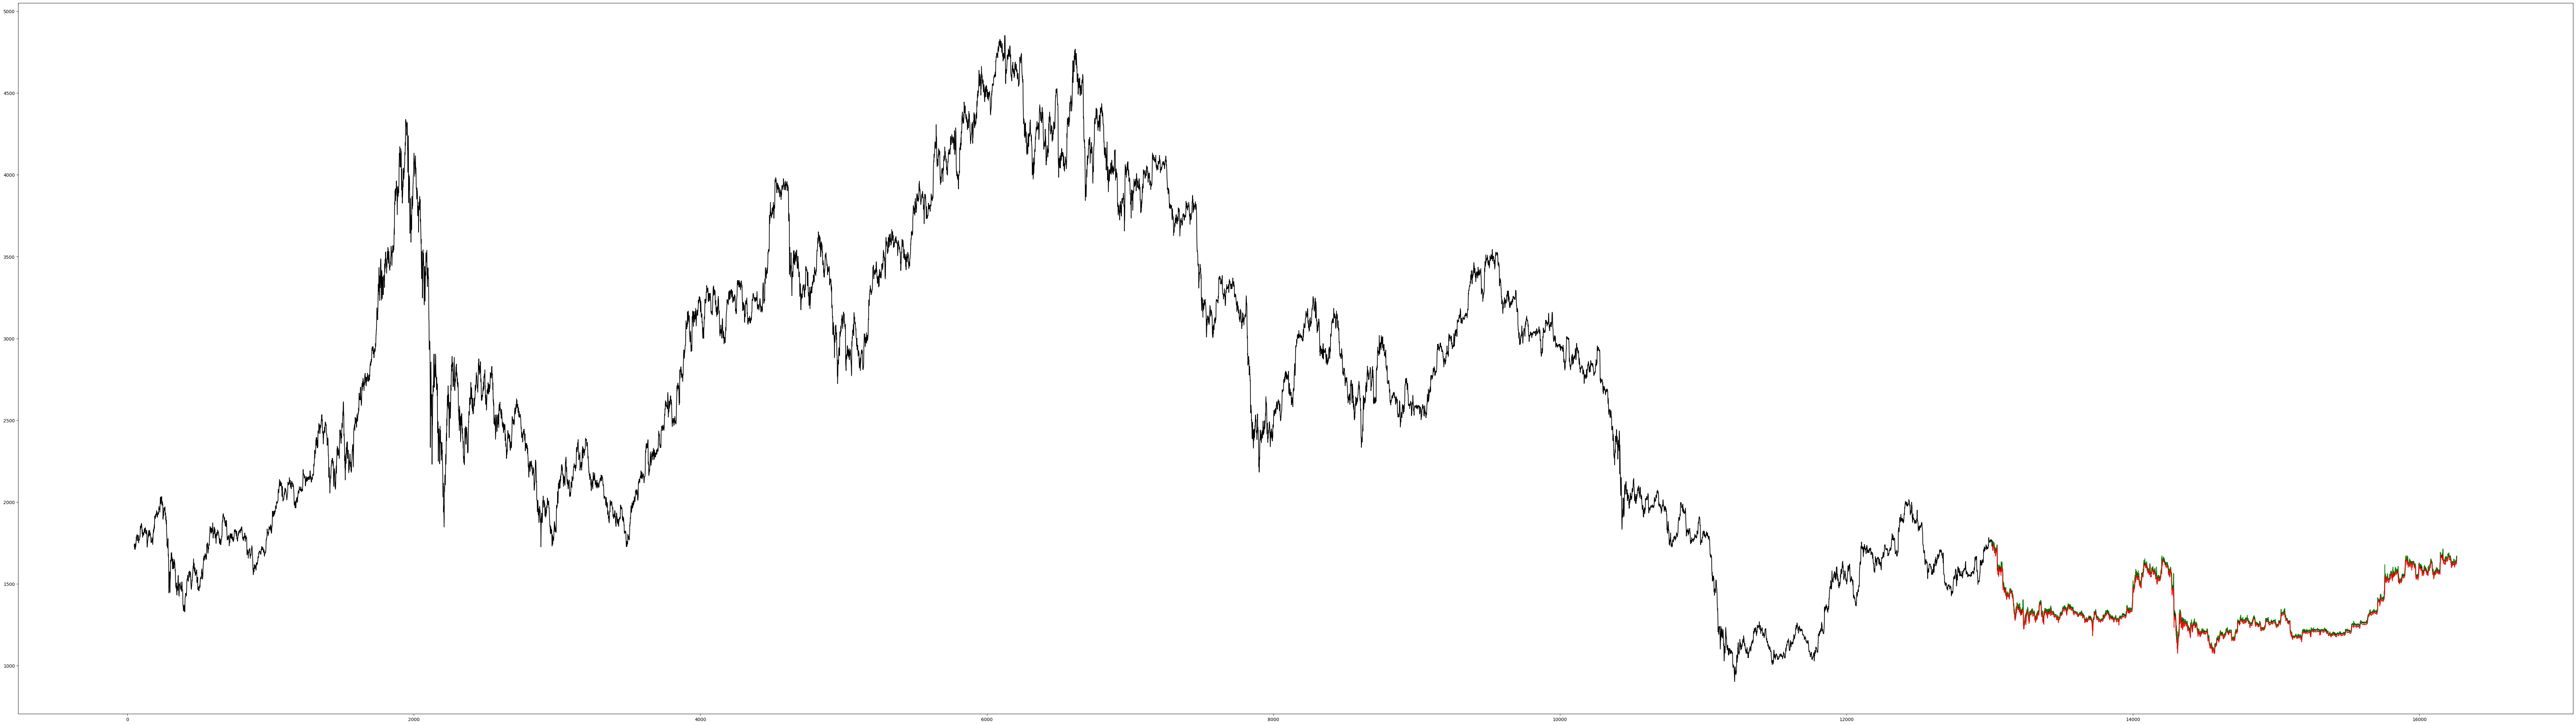

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(100, 28))

x = y_test_h.index

plt.plot(data['close'], color='black')
plt.plot(y_test_h['pred'], color='green')
plt.plot(y_test_l['pred'], color='red')
plt.fill_between(x, y_test_h['pred'], y_test_l['pred'], color='lightblue', alpha=0.7)
plt.show()

### with backup data

In [12]:
from talib import RSI
data_backup['rsi_14'] = RSI(data_backup['close'], timeperiod=14)
data_backup['rsi_14'] = data_backup['rsi_14'].shift(1)

from talib import MA, SMA, EMA
data_backup['ma_9'] = MA(data_backup['close'], timeperiod=9)
data_backup['ma_9'] = data_backup['ma_9'].shift(1)

from talib import MACD
data_backup['macd'], data_backup['signal'], data_backup['hist'] = MACD(data_backup['close'])
data_backup['macd'] = data_backup['macd'].shift(1)
data_backup['signal'] = data_backup['signal'].shift(1)
data_backup['hist'] = data_backup['hist'].shift(1)

from talib import ADX
data_backup['adx'] = ADX(data_backup['high'], data_backup['low'], data_backup['close'])
data_backup['adx'] = data_backup['adx'].shift(1)

data_backup.dropna(axis=0, inplace=True)

data_backup['high+'] = data_backup['high'].shift(1)
data_backup['low+'] = data_backup['low'].shift(1)

data_backup['high_roc'] = ( data_backup['high'] - data_backup['high'].shift(1) ) / data_backup['high'].shift(1)
data_backup['high_roc'] = data_backup['high_roc'].shift(1)
data_backup['low_roc'] = ( data_backup['low'] - data_backup['low'].shift(1) ) / data_backup['low'].shift(1)
data_backup['low_roc'] = data_backup['low_roc'].shift(1)
data_backup['rsi_14_roc'] = ( data_backup['rsi_14'] - data_backup['rsi_14'].shift(1) ) / data_backup['rsi_14'].shift(1)
data_backup['rsi_14_roc'] = data_backup['rsi_14_roc'].shift(1)
data_backup['ma_9_roc'] = ( data_backup['ma_9'] - data_backup['ma_9'].shift(1) ) / data_backup['ma_9'].shift(1)
data_backup['ma_9_roc'] = data_backup['ma_9_roc'].shift(1)

data_backup['high_roll'] = data_backup['high+'].rolling(window=14).mean()
data_backup['low_roll'] = data_backup['low+'].rolling(window=14).mean()
data_backup['rsi_14_roll'] = data_backup['rsi_14'].rolling(window=14).mean()
data_backup['ma_9_roll'] = data_backup['ma_9'].rolling(window=14).mean()

data_backup.dropna(axis=0, inplace=True)

In [13]:
inputs_high_backup = data_backup[list(best_features_high)]
target_high_backup = data_backup.iloc[:, [3]]

inputs_low_backup = data_backup[list(best_features_low)]
target_low_backup = data_backup.iloc[:, [4]]

pred_backup_high = model_h.predict(inputs_high_backup)
pred_backup_low = model_l.predict(inputs_low_backup)

252/252 [==============================] - 0s 2ms/step


In [14]:
raw_data_backup = data_backup.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11]]
raw_data_backup['pred_high'] = pred_backup_high
#raw_data_backup['pred_high'] = raw_data_backup['pred_high'].shift(1)
raw_data_backup['pred_low'] = pred_backup_low
#raw_data_backup['pred_low'] = raw_data_backup['pred_low'].shift(1)

/tmp/ipykernel_1597016/2697252308.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data_backup['pred_high'] = pred_backup_high
/tmp/ipykernel_1597016/2697252308.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data_backup['pred_low'] = pred_backup_low


In [15]:
score_backup_h = mean_squared_error(target_high_backup, pred_backup_high)
print(score_backup_h)

score_backup_l = mean_squared_error(target_low_backup, pred_backup_low)
print(score_backup_l)

100.34278155188936
178.12444873905832


In [16]:
raw_data_backup.to_excel('raw_data_best_features-high&low.xlsx')

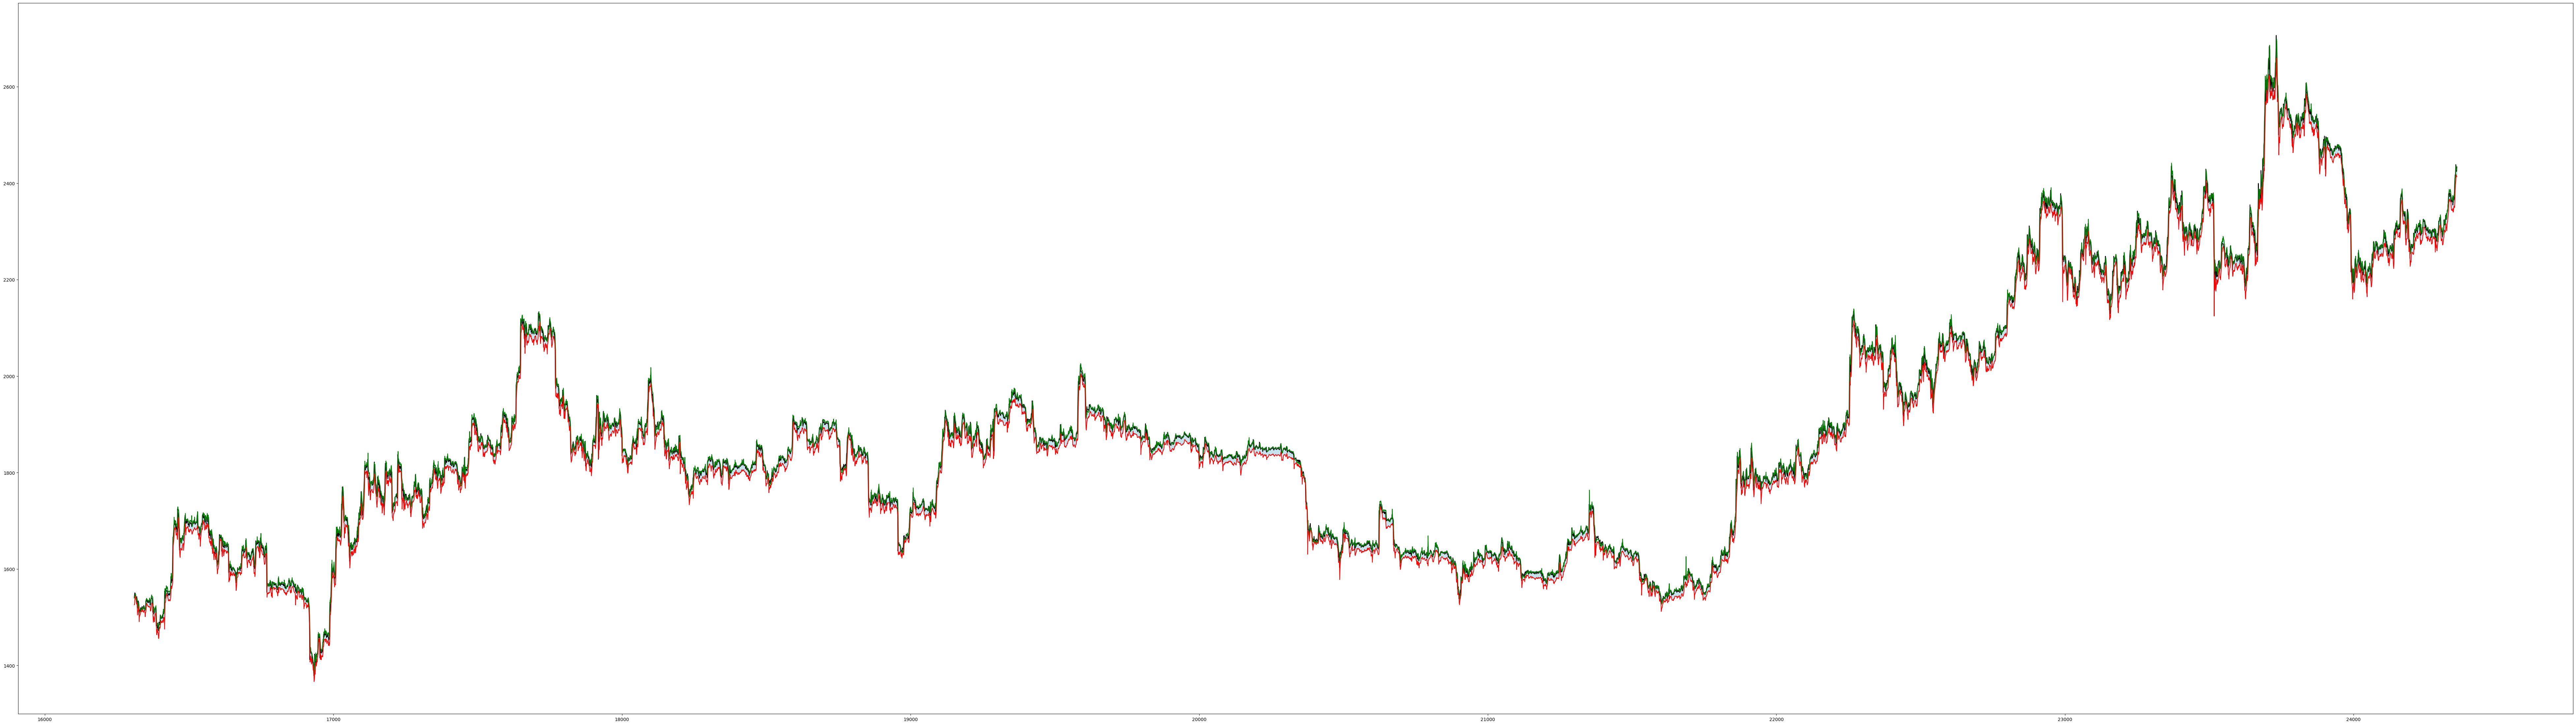

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(100, 28))

x = target_high_backup.index

plt.plot(data_backup['close'], color='black')
plt.plot(raw_data_backup['pred_high'], color='green')
plt.plot(raw_data_backup['pred_low'], color='red')
plt.fill_between(x, raw_data_backup['pred_high'], raw_data_backup['pred_low'], color='lightblue', alpha=0.7)
plt.show()